In [184]:
import numpy as np 
import tensorflow
#from tensorflow.keras.datasets import mnist
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [185]:
(train_set, train_label), (test_set, test_label) = mnist.load_data()
train_set, train_label = train_set[:20000], train_label[:20000]

In [186]:
train_set.shape

(20000, 28, 28)

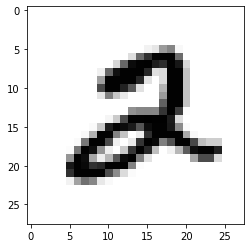

In [187]:
plt.imshow(train_set[5][:,:], cmap = plt.cm.binary)

In [188]:
#Reshape the images as a 784d vector
train_set = train_set.reshape(20000,-1)/255

In [189]:
#Binarising the data for use in Bernoulli 
train_set[train_set < 0.5] = 0
train_set[train_set > 0.5] = 1 

# Section 1. Implementing a Multi Dimensional Bernoulli random variable

Approach here is to treat each image as a vector of dimension 784. Since we normalised the image, each pixel in the image will be in the range [0,1]

Assume that for a given image vector $X_i$, it has pixels $$X_i = [x_{i1}, x_{i2}, x_{i3}, .... , x_{id}]$$Our bernoulli random variable follows the distribution $$p(x_j | \theta_j) = \theta_j^{x_j} (1 - \theta_j)^{1 - x_j}$$So for each pixel belonging to $X_i$, it follows the above distribution. The main assumption again that we follow is that the pixels in a given image are independent of each other. So by the rule of independence, we have $$\begin{equation}
p(X_i | \theta) = \Pi_{j=1}^d p(x_{ij} | \theta_j)
\end{equation}$$



Now that we know the probability distribution for a single image, we compute the total data likelihood which is the product of the above distribution for each image i.e. $$\begin{equation} p(D| \theta) = \Pi_{i = 1}^N p(X_i | \theta) \end{equation}$$
So we have $$\begin{equation} p(D | \theta) = \Pi_{i = 1}^N \Pi_{j = 1}^d \theta^{x_{ij}} (1 - \theta)^{1 - x_{ij}} \end{equation} $$

Now you can take the log likelihood of the data and differentiate w.r.t $\theta$ to get the MLE estimate of the bernoulli random variable for the mnist dataset. After differentiation we get $$\begin{equation} \theta_j^{MLE} = \frac{\Sigma_{i = 1}^N x_{ij}}{N} \end{equation}$$ which intuitively means that the $j^{th}$ component of $\theta^{MLE}$ is simply the sum of the $j^{th}$ pixel value across all images. 

Therefore this says that if we want to say get the Bernoulli Model for the MNIST, we want the $\theta$ to be the mean of each pixel across all images.

In [190]:
#Complete the code to get the MLE estimate of theta for mnist
# define theta_MLE method, get MLE estimate of theta for mnist

def get_theta_MLE(X: np.ndarray) -> np.ndarray:
    '''
    use the equation thetamle_j = sum(x_ij) / N to find MLE estimate of theta

    params:
        X: 2d numpy array of size N*j, of 0 or 1 representing an image

    returns: 
        theta_ml, 1d numpy array of size j
    '''

    n, d = X.shape # get dimensions of input array
    theta_MLE = np.zeros(d) # initialize output array size

    for j in range(d): # iterate up to j, use equation
        theta_MLE[j] = sum(X[i][j] for i in range(n)) / n 

    return theta_MLE 

theta_MLE = get_theta_MLE(train_set) # outputs 1x784 array

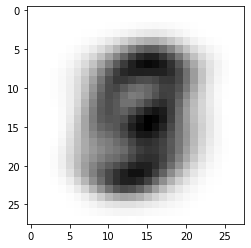

In [191]:
#Visualisation of the MLE estimate
theta_MLE = theta_MLE.reshape(28,28)*255
plt.imshow(theta_MLE, cmap = plt.cm.binary)

# Section 2. Implementing KMeans on MNIST to cluster data

So we have studied KMeans as a very intuitive approach to clustering data. Suppose we want to categorize each image into a specific cluster. How do we do that ? 

In [192]:
def calcSqDistances(X, Kmus):

    '''
    assign each data vector to closest mu vector as per Bishop (9.2)
    do this by first calculating a squared distance matrix where the n,k entry
    contains the squared distance from the nth data vector to the kth mu vector
    '''

    # get dimensions
    n, d = X.shape
    k = len(Kmus)

    # initialize array of all zeroes
    distances = np.zeros((n, k))

    # iterate through X and Kmus, populate array
    for i, data in enumerate(X):
        for j, mu in enumerate(Kmus):
            distances[i][j] = np.linalg.norm(data - mu)

    return distances

In [193]:
def determineRnk(sqDmat):
    '''
    given the matrix of squared distances, determine the closest cluster
    center for each data vector
    '''

    # get dimensions
    len_m, len_n = len(sqDmat), len(sqDmat[0])

    # initialize array of all zeroes, get minima of axis
    responsibility = np.zeros((len_m, len_n))
    min_axis = np.argmin(sqDmat.T, axis = 0)

    for i, j in enumerate(min_axis):
        responsibility[i][j] = 1
    
    return responsibility

In [194]:
def recalcMus(X, rnk):
    '''
    recalculate mu values based on cluster assignments as per Bishop (9.4)
    '''
    
    xTranspose = X.T # get transpose of X
    dotProd = xTranspose.dot(rnk) # dot product of X^T(x transpose) and rank
    rankSum = sum(rnk) # sum of rank
        
    musMatrix = (dotProd/rankSum).T # get new mu matrix and transpose
    
    return musMatrix

In [195]:
def runKMeans(K):
    #load data file specified by fileString from Bishop book
    X = train_set

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            #print(iter)
            break
    return Kmus

In [196]:
Kmus_10 = runKMeans(10)
Kmus_20 = runKMeans(20)

KeyboardInterrupt: 

# We can see which cluster roughly represents which digit. 

In [ ]:
def get_cluster_plot(Kmus,rows): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

In [ ]:
get_cluster_plot(Kmus_10,2) #Get cluster representation for K = 10 clusters
get_cluster_plot(Kmus_20,4) #Get cluster representation for K = 20 clusters

# 3. Implementation of a Mixture of Bernoulli Distributions

We have seen the performance of a single Bernoulli Distribution on the dataset. We saw it was not very good. On the other hand, using KMeans, we saw that same digits are having different cluster centers based on the writing style. Ex : In the image above, we can see that 0 is associated with clusters 5,7,13 and so on. So we hypothesise that a single digit cannot be entirely sampled from a single distribution and hence a mixture model maybe able to better explain the datas. 

Let us assume that our model is actually a Mixture of Multivariate Bernoulli random variable. For now, let us assume that the model consists of 10 multivariate bernoulli distributions. In this case, given a vector of pixel values, we don't know which cluster it belongs to. So let $z = \{1,2,3,4,5,...,10\}$ represent the cluster numbers. Each cluster is a multivariate bernoulli random variable and hence $$\begin{equation} p(x | z = k) = \prod_{j = 1}^d \theta_{kj}^{x_j} (1 - \theta_{kj})^{1 - x_j}  \\ ∀ k ∈ \{1,2,...,10\} \end{equation} $$ where $p(z = k) = \pi_k$
Using this we write $$p(x,z) = p(x | z = k) p(z = k) = \prod_{k = 1}^{10} (\pi_k p(x | \theta_k))^{z_k} $$ where $z_k = 1$ if the data point belongs to cluster k. This is the one hot encoding trick discussed in class. Now given a dataset $D = \{x_1, x_2, x_3, ...., x_N\}$, the likelihood can be written as $$p(X, Z) = \prod_{i = 1}^N p(x_i, z) = \prod_{i = 1}^N \prod_{k = 1}^{10} (\pi_k p(x_i | \theta_k))^{z_{ik}}$$ This is the total data likelihood that we want to maximize in the presence of unknown/latent variables. Taking the log of this, we have $$log(p(X,Z)) = \sum_{i = 1}^N \sum_{k = 1}^{10} z_{ik} log(p(x_i | z = k) = \sum_{i = 1}^N \sum_{k = 1}^{10} z_{ik} (log(\pi_k) + \sum_{j = 1}^d (x_{ij}log(\theta_{kj}) + (1 - x_{ij})log(1 - \theta_{kj})))$$ This is the function that we would like to maximise and get the optimal values of $\theta$ and $\pi$. But since the latent variables are unknow, what we do is we take the expectation of this expression wrt observed data $X$ and some initial guess for the parameters that we want to find $\theta$ and $\pi$. The only expression above that depends on the latent variable is $z_{ik}$ and since this is a one hot encoding variable, we know that $$E[z_{ik} | X; \theta^o, \pi^o] = P(z_{ik} = k | X; \theta^o, \pi^o)$$ Applying Bayes Theorem, we have $$P(z_{ik} = k | X; \theta^o, \pi^o) = \frac{P(X | z_{ik} = k;  \theta^o, \pi^o) P(z_{ik} = k)}{\sum_{k = 1}^{10} P(X | z_{ik} = k;  \theta^o, \pi^o) P(z_{ik} = k)}$$ from which we have $$ \gamma_{ik} = \frac{\pi_k^o P(x_i | z = k; \theta_k ^o)}{\sum_{m = 1}^{10} \pi_m^o P(x_i | z = m; \theta_m ^ o)} $$ This is the E step of the EM algorithm. Now we have the expectation of the total data log likelihood as $$Q(\theta, \pi; \theta^o, \pi^o ) = E[log(p(X,Z))] = \sum_{i = 1}^N \sum_{k = 1}^{10} \gamma_{ik} (log(\pi_k) + \sum_{j = 1}^d (x_{ij}log(\theta_{kj}) + (1 - x_{ij})log(1 - \theta_{kj})))$$ Now our aim in the M step is to find optimal parameters $\theta$ and $\pi$ that maximize the Q function $Q(\theta, \pi; \theta^o, \pi^o )$ subject to constraints $\sum_{k = 1}^{10} \pi_k = 1$ The result of the optimisation process is as follows 
$$\pi_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik}}{N}$$ and $$\theta_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik} x_{i}}{\sum_{i = 1}^N \gamma_{ik}}$$

Thus, we have arrived at the end of M step. Now we repeat the process untill the change in parameters in negligible. So overall, the EM algorithm for Mixture of Bernoulli can be summarised as follows :- 
1. Start with a guess of parameters $\pi^o$ and $\theta^o$ where $\sum_{k = 1}^{10} \pi^o = 1$. 
2. E step : Compute $\gamma_{ik}$ for $i \in \{1,2,...,N\}$ and $k \in \{1,2,3...,10\}$ 
$$\gamma_{ik} = \frac{\pi_k^o P(x_i | z = k; \theta_k ^o)}{\sum_{m = 1}^{10} \pi_m^o P(x_i | z = m; \theta_m ^ o)} $$
3. M step: Find the next iteration values of parameters $\pi^{o + 1}$ and $\theta^{o + 1}$ $$\pi_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik}}{N}$$ $$\theta_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik} x_{i}}{\sum_{i = 1}^N \gamma_{ik}}$$

Using this framework, lets try to build a mixture model for the dataset.

In [197]:
def train_EM_MOB(x , pi, theta, K = 10): 
    '''
    :input arguments ---> data set, mixture probabilities, initial cluster locations and number of mixtures
    : Implement the EM algorithm for Mixture of Bernoulli random variables
    : HINT -> We strongly recommend to avoid two nested for loops. Try vectorising your code. 
    : A simple example of vectorisation is as follows :- 
    : Assume you have two vectors a and b. Suppose you want to find out the dot product of a and b. 
    : There are two ways -> 1. sum = 0 ; for i in range(len(a)): sum += a[i]*b[i] 
    : 2. sum = a.T @ b
    : The second method uses the matrix properties to get the same result as first. This is the main idea. 
    : Also it is a good idea to try out your own code with a small minibatch of data instead of the full data. 
    '''
    #print(theta.shape)
    max_itr = 100
    i = len(x) # 784 pixels
    # K = # clusters

    for itr in range(max_itr):
        out = np.array(np.zeros((i,K), dtype=np.float64))
        den = np.array(np.zeros((1,i), dtype=np.float64))
        #print("i den", den.shape)
        # E step, find gamma not done last line
        for cluster in range(K):
            mat1 = np.power(theta[cluster],x)
            mat2 = np.power(1-theta[cluster],1-x)
            out[:,cluster] = pi[cluster]*np.prod(mat1*mat2,axis=1)
        #print(out)
        #print("2 out: ", out.shape)
        den = np.array(1/(np.sum(out,axis=1))) # fix this line
        #print("den: ",den.shape)
        #print("out: ", out.shape)
        #print(1/den)

        gam = np.array((out.T*den), dtype=np.float64).T
        #print("GAM: ", gam.shape)
        print("DEN")
        print(den)
        print("OUT")
        print(out)
        print("GAM")
        print(gam)
        #gam = (den*out.T).T

        #print(gam.shape)
        # M step, update parameters
        pi = np.sum(gam,axis=0)/i
        theta = np.sum(x@gam,axis=1)/np.sum(gam,axis=1) # should be (10, 784)
        
    print("new Theta: ", theta.shape)
    return pi, theta


In [198]:
# intialization done
train = train_set
#Initialise the P(z = k) = $$\pi_k$$
pi = np.array([0.1]*10)
#Initialise theta
# any random values 0.1 - 0.5 to keep moderate data rather than [0,1]
theta = np.random.uniform(0.1,0.5,size=(10,784))
#First try out with a small dataset
#pi_new, theta_new = train_EM_MOB(train[:500] , pi , theta)
pi_new, theta_new = train_EM_MOB(train[:784] , pi , theta)

#After ensuring it works as expected, run on full dataset

#pi_new, theta_new = train_EM_MOB(train , pi, theta)

DEN
[1.09644448e+165 5.09237133e+169 4.22684981e+155 6.85992107e+148
 9.25267159e+158 8.08967706e+167 4.60550353e+150 7.13989014e+180
 3.87041214e+141 2.06451619e+156 2.95887583e+167 8.78138015e+145
 4.72498553e+177 6.94495389e+168 2.49335842e+139 3.71030262e+162
 7.50229542e+162 1.03354774e+167 5.05277244e+141 2.26399072e+149
 2.08535530e+176 5.10363779e+176 5.85314420e+147 1.51894820e+148
 2.29579934e+157 3.29893585e+185 2.44321851e+144 5.23544191e+193
 4.64900262e+188 1.21365075e+146 1.10690958e+165 1.12656726e+174
 6.41898621e+149 1.61829073e+155 3.53076299e+178 1.61713074e+150
 8.30897079e+171 6.01737596e+182 8.67888741e+154 1.92659275e+164
 6.26319378e+147 2.32541640e+169 1.44296378e+144 1.21074185e+151
 6.47167552e+151 2.13099212e+160 1.72301474e+159 9.27601753e+161
 6.53262826e+149 3.27202953e+172 2.99669631e+151 1.45040044e+190
 2.94811855e+166 1.76994740e+150 1.00590059e+159 6.61641273e+174
 3.98899567e+191 3.07952840e+155 1.62897486e+176 8.49687065e+149
 1.56702829e+172 3.88

/var/folders/ys/v1tsy76d4n9f94m49cv1sqnr0000gn/T/ipykernel_83340/662021302.py:34: RuntimeWarning: invalid value encountered in multiply
  gam = np.array((out.T*den), dtype=np.float64).T


DEN
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

ValueError: cannot reshape array of size 1 into shape (28,newaxis)

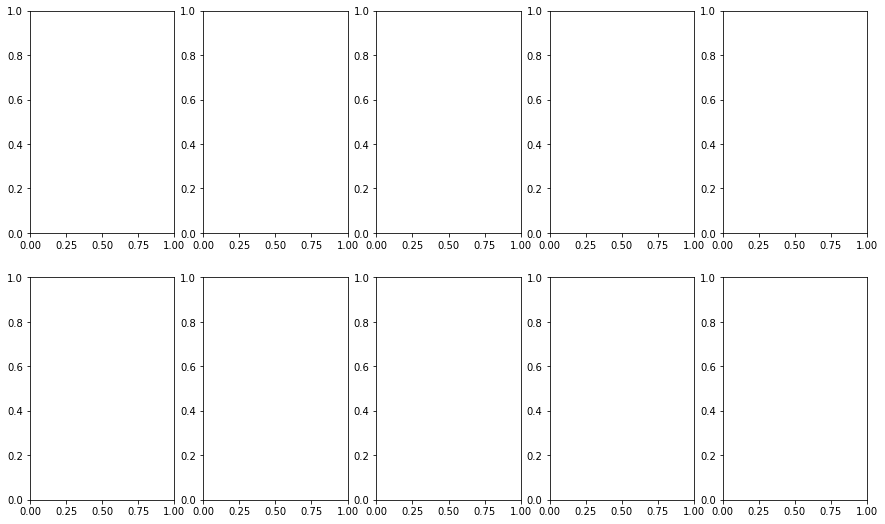

In [203]:
#Visualise the 10 clusters that you obtained

get_cluster_plot(theta_new, 2) #Get the cluster representation for a mixture model with 10 mixtures

$$\pi_k$$